In [58]:
spark.stop()

# Set paths

DEVEL_SRC must contain the directory use-cases and pykhaos

In [1]:
import os, sys
import datetime as dt
DEVEL_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel")
if DEVEL_SRC not in sys.path:
    sys.path.append(DEVEL_SRC)

USECASES_SRC = os.path.join(DEVEL_SRC, "use-cases") # TODO when '-' is removed from name, remove also this line and adapt imports 
if USECASES_SRC not in sys.path: 
    sys.path.append(USECASES_SRC)
    
# AMDOCS_SRC = os.path.join(DEVEL_SRC, "amdocs_informational_dataset") # TODO when - is removed, remove also this line and adapt imports
# if AMDOCS_SRC not in sys.path: 
#     sys.path.append(AMDOCS_SRC)
    
import pykhaos.utils.custom_logger as clogger
logging_file = os.path.join(os.environ.get('BDA_USER_HOME', ''), "logging",
                                    "out_" + dt.datetime.now().strftime("%Y%m%d_%H%M%S") + ".log")
logger = clogger.configure_logger(log_filename=logging_file, std_channel=sys.stderr, logger_name="")
logger.info("Logging to file {}".format(logging_file))    
        
from project.project_generic import Project

import pykhaos.utils.notebooks as nb

import time
start_time = time.time()

RUNNING_FROM_NOTEBOOK = nb.isnotebook()
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
if RUNNING_FROM_NOTEBOOK:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline  
    EXTERNAL_LIB = os.path.join(os.environ.get('BDA_USER_HOME', ''), "lib", "external_libs")
    if EXTERNAL_LIB not in sys.path:
        sys.path.append(EXTERNAL_LIB)
    # feel free from commenting this line and the other ones that begin with "%%notify" if you do not have 
    # the extension installed or copy de lib from /var/SP/data/home/csanc109/lib/external_libs/jupyternotify/
    %load_ext jupyternotify 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

20190624-113319 [INFO ] Logging to file /var/SP/data/home/csanc109/logging/out_20190624_113319.log


<IPython.core.display.Javascript object>

In [2]:
from pyspark.sql import Row, DataFrame, Column, Window
from pyspark.sql.types import DoubleType, StringType, IntegerType, DateType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import collect_set, concat, size, coalesce, col, lpad, struct, count as sql_count, lit, min as sql_min, max as sql_max, collect_list, udf, when, desc, asc, to_date, create_map, sum as sql_sum
from pyspark.sql.types import StringType, ArrayType, MapType, StructType, StructField, IntegerType
from pyspark.sql.functions import array, regexp_extract
from itertools import chain
from churn.datapreparation.general.data_loader import get_unlabeled_car, get_port_requests_table, get_numclients_under_analysis
from churn.utils.constants import PORT_TABLE_NAME
from churn.utils.udf_manager import Funct_to_UDF
from pyspark.sql.functions import substring, datediff, row_number
from pykhaos.utils.date_functions import move_date_n_days, move_date_n_cycles
from pykhaos.utils.hdfs_functions import check_hdfs_exists
from pykhaos.modeling.model_performance import get_lift

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Functions

In [249]:
def compute_l2(df_tar):
    if "total_data_volume" in df_tar.columns:
        df_tar = df_tar.withColumn("total_data_volume", when(col("total_data_volume")<0, 0).otherwise(col("total_data_volume")))
        
    if "total_mou_w" in df_tar.columns:
        df_tar = df_tar.withColumn("total_mou_w", when(col("total_mou_w")<0, 0).otherwise(col("total_mou_w")))
    
    if "total_mou_we" in df_tar.columns:
        df_tar = df_tar.withColumn("total_mou_we", when(col("total_mou_we")<0, 0).otherwise(col("total_mou_we")))
          
    if "total_mou_we" in df_tar.columns and "total_mou_w" in df_tar.columns:
        df_tar = df_tar.withColumn("total_mou", col("total_mou_we")+col("total_mou_w"))
        
    return df_tar

def get_prepared_car(closing_day, start_date, end_date, ref_date=None, select_columns=None, force=True, save=False):
    
    if not ref_date:
        ref_date = closing_day
    
    path_to_file = '/user/csanc109/projects/triggers/df_{}_{}'.format(closing_day, start_date + "to" + end_date)
    

    if not check_hdfs_exists(path_to_file) or force:
    
        df_tar = spark.read.option('sep', '|').option('header', 'true').csv(path_to_file)
 


        df_car = spark.read.table("tests_es.jvmm_amdocs_prepared_car_mobile_complete_{}".format(closing_day))    
        df_ef = spark.read.parquet("/data/udf/vf_es/churn/extra_feats_mod/extra_feats/year={}/month={}/day={}".format(closing_day[:4], int(closing_day[4:6]), int(closing_day[6:]))).drop("nif_cliente", "rgu", "num_cliente", "campo1", "campo2")
        df_car = df_car.join(df_ef, on=["msisdn"], how="left")
        
        
        df_car = compute_l2(df_car)
     


        print("Get port requests table: start={} end={} ref_date={}".format(start_date, end_date, ref_date))


        window = Window.partitionBy("msisdn_a").orderBy(desc("days_from_portout")) # keep the 1st portout

        start_date_obj = Funct_to_UDF.convert_to_date(start_date)
        end_date_obj = Funct_to_UDF.convert_to_date(end_date)

        convert_to_date_udf = udf(Funct_to_UDF.convert_to_date, StringType())

        df_sol_port = (spark.read.table(PORT_TABLE_NAME)
                      .where((col("sopo_ds_fecha_solicitud") >= start_date_obj) & (col("sopo_ds_fecha_solicitud") <= end_date_obj))
                      .withColumnRenamed("SOPO_DS_MSISDN1", "msisdn_a")
                      .withColumnRenamed("SOPO_DS_FECHA_SOLICITUD", "portout_date")
                      .withColumn("portout_date", substring(col("portout_date"), 0, 10))
                      .withColumn("portout_date", convert_to_date_udf(col("portout_date")))
                      .withColumn("ref_date",
                                  convert_to_date_udf(concat(lit(ref_date[:4]), lit(ref_date[4:6]), lit(ref_date[6:]))))
                      .withColumn("days_from_portout", datediff(col("ref_date"), col("portout_date")).cast("int"))
                      .withColumn("rank", row_number().over(window))
                          .where(col("rank") == 1))

        df_sol_port = df_sol_port.withColumn("label", lit(1.0)).withColumnRenamed("msisdn_a", "msisdn").select("msisdn", "label")

        print("sol_port = {} -- {}".format(df_sol_port.count(), ",".join(df_sol_port.columns)))
        # df_sol_port cols:msisdn_d_port,label

        df_tar = (df_car.join(df_sol_port, on=["msisdn"], how="left").na.fill({'label': 0.0}))

        if select_columns:
            df_tar = df_tar.select(select_columns)

        
        #print("df_tar", ",".join(df_tar.columns))
        nb_rows_tar = df_tar.count()
        print("[Info DataLoader] Number of msisdns: df_tar={} ".format(nb_rows_tar))
        if nb_rows_tar>0:
            print("Num port outs in labeled car {}".format(df_tar.select("label").rdd.map(lambda x: (1, x[0])).reduceByKey(
                lambda x, y: x + y).collect()[0][1]))

        from churn.datapreparation.app.generate_table_extra_feats_new import impute_nulls
        df_tar = impute_nulls(df_tar, spark, metadata_version="1.1")
        if save:
            print("Saving {}".format(path_to_file))
            df_tar.coalesce(1).write.mode('overwrite').format('csv').option('sep', '|').option('header', 'true').save(path_to_file)
            print("Saved {}".format(path_to_file))
    else:
        print("Reading {}".format(path_to_file))
        df_tar = spark.read.option('sep', '|').option('header', 'true').csv(path_to_file)
       
        df_tar = compute_l2(df_tar)
        
        if select_columns:
            df_tar = df_tar.select(select_columns)

        for col_ in int_feats:
            df_tar = df_tar.withColumn(col_, col(col_).cast("int"))
            
        for col_ in float_feats:
            df_tar = df_tar.withColumn(col_, col(col_).cast("float"))

        df_tar = df_tar.withColumn(label_col, col(label_col).cast("int"))
            
    return df_tar

# from pykhaos.utils.pyspark_utils import count_nans
# A = count_nans(trdf)
# A

def get_metrics(df_preds, label="", nb_deciles=10):
    
    preds_and_labels = df_preds.select(['model_score', 'label']).rdd.map(lambda r: (r['model_score'], float(r['label'])))

    my_metrics = BinaryClassificationMetrics(preds_and_labels)

    print("METRICS FOR {}".format(label))
    print("\t AUC = {}".format(my_metrics.areaUnderROC))
    if nb_deciles:
        lift = get_lift(df_preds, 'model_score', 'label', nb_deciles)

        for d ,l in lift:
            print "\t" + str(d) + ": " + str(l)


def plot_hist(data):
    
    import numpy as np
    import matplotlib.pyplot as mplt
    import matplotlib.ticker as mtick
    
    binSides, binCounts = data

    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = mplt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')

    ax.set_ylabel('Frequencies')
    ax.set_title('Histogram')
    ax.set_xticks(np.arange(N+1))
    ax.set_xticklabels(binSides)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

    mplt.show()
    
def filter_car(df_tar):
    print("BEFORE {}".format(df_tar.count()))
    from churn.datapreparation.general.data_loader import get_numclients_under_analysis
    df_nc_mobileandfbb = get_numclients_under_analysis(spark, config_obj=None, closing_day=closing_day, segment_filter="mobileandfbb", new=False)
    df_tar = df_tar.join(df_nc_mobileandfbb, on=["NUM_CLIENTE"], how="inner")
    print("AFTER1 {}".format(df_tar.count()))

    df_tar = (df_tar.where(col("ccc_num_interactions")>0)
                   .where(col("total_mou")>0)
                   .where(col("total_data_volume")>0)
                   .where(col("total_data_volume")<45000)
                   .where(col("total_mou")<4500)
                   .where(col("device_days_since_device_n1_change_date")<4000))



    print("AFTER2 {}".format(df_tar.count()))

    return df_tar

## Start spark context

In [4]:
from churn.utils.general_functions import init_spark
spark = init_spark("triggers")
sc = spark.sparkContext

Ended spark session: 840.816717863 secs | default parallelism=2


# Input params

In [5]:
closing_day = "20190414"
start_date = closing_day
end_date = move_date_n_days(closing_day, n=+30)

ref_date = end_date

# Config 

In [250]:
int_feats =  ['ccc_num_interactions', 'ccc_num_ivr_interactions', 'device_days_since_device_n1_change_date', 'device_tenure_days_n2'] 
float_feats = ['additional_inc_bill_n1_n2_net', 'additional_inc_bill_n1_n3_net', 'additional_inc_bill_n1_n4_net', "total_data_volume", "total_mou"]# "total_mou_w", "total_mou_we"] 

numerical_feats = int_feats + float_feats
noninf_feats = ['msisdn', "NUM_CLIENTE"]

label_col = 'label'

COLS = numerical_feats + noninf_feats + [label_col]

feat_cols = numerical_feats # notebook is not still prepared for categoricals.



# Get current car (for train and test) and other car (for validation)

In [327]:
df_tar_all = get_prepared_car(closing_day, start_date, end_date, select_columns=COLS, force=False, save=True)
df_tar = filter_car(df_tar_all)

Reading /user/csanc109/projects/triggers/df_20190414_20190414to20190514
BEFORE 6224707
Calling get_numclients_under_analysis for closing_day=20190414 and segment_filter=mobileandfbb
*********** NUM_CLIENTE,bam_services_nc,bam_fx_first_nc,fbb_services_nc,fbb_fx_first_nc,mobile_services_nc,mobile_fx_first_nc,fixed_services_nc,fixed_fx_first_nc,tv_services_nc,tv_fx_first_nc,prepaid_services_nc,prepaid_fx_first_nc,bam_mobile_services_nc,bam_mobile_fx_first_nc,flag_prepaid_nc,seg_pospaid_nc,bam_services_nif,bam_fx_first_nif,fbb_services_nif,fbb_fx_first_nif,mobile_services_nif,mobile_fx_first_nif,fixed_services_nif,fixed_fx_first_nif,tv_services_nif,tv_fx_first_nif,prepaid_services_nif,prepaid_fx_first_nif,bam_mobile_services_nif,bam_mobile_fx_first_nif,flag_prepaid_nif,seg_pospaid_nif,SUPEROFERTA_EXONO_PREOW,GRUPO_EXONO_PREOW,num_football_nc,total_football_price_nc,num_football_nif,total_football_price_nif,total_num_services_nc,fx_bam_fx_first_nc,days_since_bam_fx_first_nc,fx_bam_mobile_fx

In [328]:
df_next_tar_all = get_prepared_car(move_date_n_cycles(closing_day,n=+1), move_date_n_cycles(start_date,n=+1), move_date_n_cycles(end_date,n=+1), select_columns=COLS, force=True, save=True)
df_next_tar = filter_car(df_next_tar_all)

Get port requests table: start=20190421 end=20190521 ref_date=20190421
sol_port = 160867 -- msisdn,label
[Info DataLoader] Number of msisdns: df_tar=6227319 
Num port outs in labeled car 91993.0


20190613-143912 [INFO ] df_metadata=DataFrame[feature: string, source: string, type: string, imputation: string]
20190613-143912 [INFO ] df_metadata=DataFrame[feature: string, source: string, type: string, imputation: string]
20190613-143912 [INFO ] about to call fillna
20190613-143912 [INFO ] after call to fillna


Saving /user/csanc109/projects/triggers/df_20190421_20190421to20190521
Saved /user/csanc109/projects/triggers/df_20190421_20190421to20190521
BEFORE 6227319
Calling get_numclients_under_analysis for closing_day=20190414 and segment_filter=mobileandfbb
*********** NUM_CLIENTE,bam_services_nc,bam_fx_first_nc,fbb_services_nc,fbb_fx_first_nc,mobile_services_nc,mobile_fx_first_nc,fixed_services_nc,fixed_fx_first_nc,tv_services_nc,tv_fx_first_nc,prepaid_services_nc,prepaid_fx_first_nc,bam_mobile_services_nc,bam_mobile_fx_first_nc,flag_prepaid_nc,seg_pospaid_nc,bam_services_nif,bam_fx_first_nif,fbb_services_nif,fbb_fx_first_nif,mobile_services_nif,mobile_fx_first_nif,fixed_services_nif,fixed_fx_first_nif,tv_services_nif,tv_fx_first_nif,prepaid_services_nif,prepaid_fx_first_nif,bam_mobile_services_nif,bam_mobile_fx_first_nif,flag_prepaid_nif,seg_pospaid_nif,SUPEROFERTA_EXONO_PREOW,GRUPO_EXONO_PREOW,num_football_nc,total_football_price_nc,num_football_nif,total_football_price_nif,total_num_servi

# Train them first model to extract important variables

In [239]:
[df_unbaltr, df_tt] = df_tar.randomSplit([0.7, 0.3], 1234)

#print "[Info FbbChurn] " + time.ctime() + " Total number of training samples is : " + str(unbaltrdf.count())

df_unbaltr.describe('label').show()

print " Stat description of the target variable printed above"

# 1.2. Balanced df for training

df_unbaltr.groupBy('label').agg(sql_count('*')).show()

print " Count on label column for unbalanced tr set showed above"

from churn.models.fbb_churn_amdocs.utils_general import balance_df2
df_tr = balance_df2(df_unbaltr, 'label')

df_tr.groupBy('label').agg(sql_count('*')).show()

print " Count on label column for balanced tr set showed above"

# 1.3. Feature selection

# allFeats = trdf.columns

for f in noninf_feats:
    print "Non-informative feat: " + f


+-------+--------------------+
|summary|               label|
+-------+--------------------+
|  count|              357101|
|   mean|0.025004130484092734|
| stddev|  0.1561377347472626|
|    min|                   0|
|    max|                   1|
+-------+--------------------+

 Stat description of the target variable printed above
+-----+--------+
|label|count(1)|
+-----+--------+
|    1|    8929|
|    0|  348172|
+-----+--------+

 Count on label column for unbalanced tr set showed above
[Info balance_df2] Dataframe has been balanced - Total number of rows is 17901
+-----+--------+
|label|count(1)|
+-----+--------+
|    1|    8929|
|    0|    8972|
+-----+--------+

 Count on label column for balanced tr set showed above
Non-informative feat: msisdn
Non-informative feat: NUM_CLIENTE


# Model

In [243]:

logger.info("Feat cols = {}".format(",".join(feat_cols)))

assembler = VectorAssembler(inputCols = feat_cols, outputCol = "features")

classifier = RandomForestClassifier(featuresCol="features", \
                                    labelCol="label", \
                                    maxDepth=25, \
                                    maxBins=32, \
                                    minInstancesPerNode=50, \
                                    impurity="gini", \
                                    featureSubsetStrategy="sqrt", \
                                    subsamplingRate=0.7, \
                                    numTrees=250, \
                                    seed = 1234)

pipeline = Pipeline(stages= [assembler, classifier])

model = pipeline.fit(df_tr)

from churn.models.fbb_churn_amdocs.utils_model import getOrderedRelevantFeats
feat_importance = getOrderedRelevantFeats(model, feat_cols, 'f', 'rf')

for fimp in feat_importance:
    print "Imp feat " + str(fimp[0]) + ": " +  str(fimp[1])

# EVALUATION
# TODO: to include model calibration

# Calibration
#calibmodel = get_calibration_function2(spark, model, valdf, 'label', 10)
#getScore = udf(lambda prob: float(prob[1]), DoubleType())

getScore = udf(lambda prob: float(prob[1]), DoubleType())

# Train evaluation
df_tr_preds = model.transform(df_tr).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))
#trPredictionAndLabels = df_tr_preds.select(['model_score', 'label']).rdd.map(lambda r: (r['model_score'], float(r['label'])))


# Test eval
df_tt_preds = model.transform(df_tt).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))

# Evaluation 
df_val_preds = model.transform(df_next_tar).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))




20190613-084439 [INFO ] Feat cols = ccc_num_interactions,ccc_num_ivr_interactions,device_days_since_device_n1_change_date,device_tenure_days_n2,additional_inc_bill_n1_n2_net,additional_inc_bill_n1_n3_net,additional_inc_bill_n1_n4_net,total_data_volume,total_mou


Imp feat device_days_since_device_n1_change_date: 0.1930537449565467
Imp feat ccc_num_interactions: 0.17340892438081773
Imp feat device_tenure_days_n2: 0.11585982268254011
Imp feat total_data_volume: 0.10861543134535676
Imp feat total_mou: 0.10628811224771567
Imp feat additional_inc_bill_n1_n4_net: 0.09987553573978039
Imp feat additional_inc_bill_n1_n2_net: 0.09321802272201797
Imp feat additional_inc_bill_n1_n3_net: 0.08847266092171562
Imp feat ccc_num_ivr_interactions: 0.021207745003509092


In [244]:
# Validation
get_metrics(df_tr_preds, label="train", nb_deciles=None)
get_metrics(df_tt_preds, label="test",  nb_deciles=None)
get_metrics(df_val_preds, label="validation",  nb_deciles=None)


METRICS FOR train
	 AUC = 0.701602718968
METRICS FOR test
	 AUC = 0.626634439181
METRICS FOR validation
	 AUC = 0.633079729516


# Evaluation

In [16]:
# Checking scores

In [ ]:
    
# plot_hist(df_tr_preds.select("model_score").rdd.flatMap(lambda x: x).histogram(50))
# plot_hist(df_tt_preds.select("model_score").rdd.flatMap(lambda x: x).histogram(50))
# plot_hist(df_val_preds.select("model_score").rdd.flatMap(lambda x: x).histogram(50))


In [142]:
df_tr_preds.select(sql_max("ccc_num_interactions")).collect()

[Row(max(ccc_num_interactions)=149)]

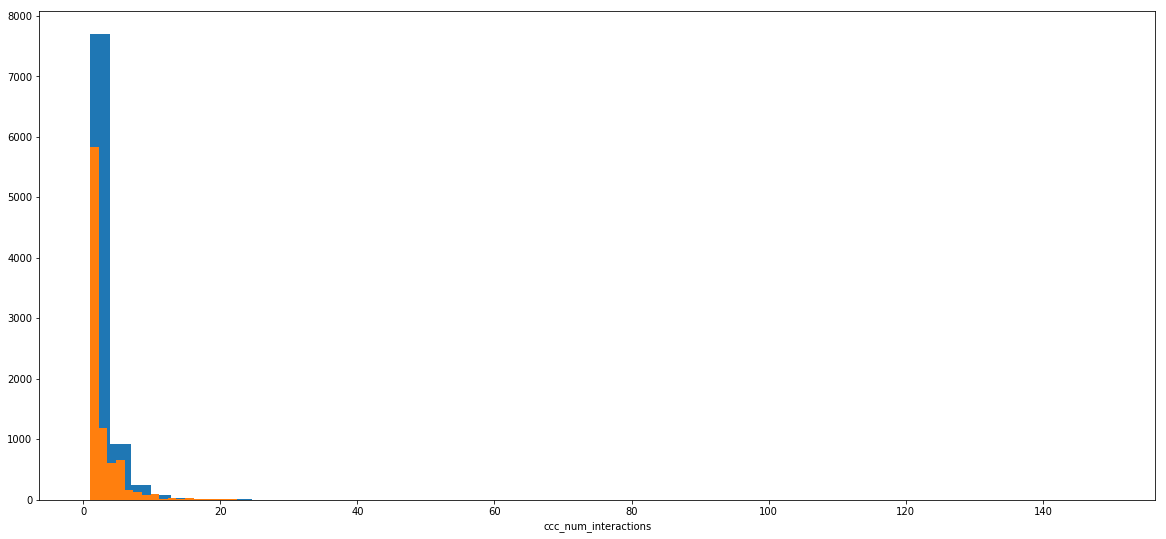

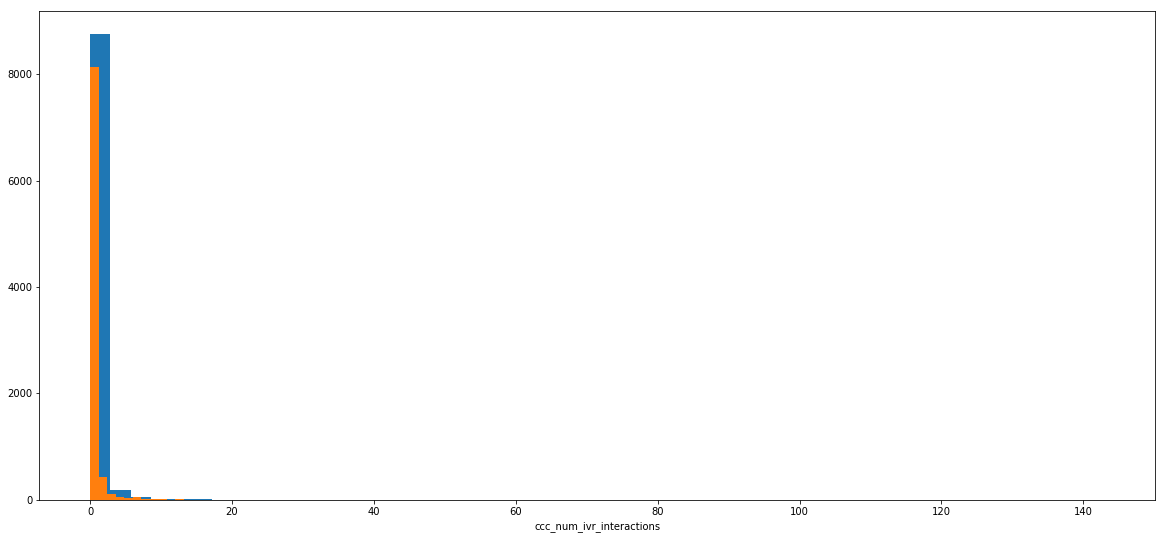

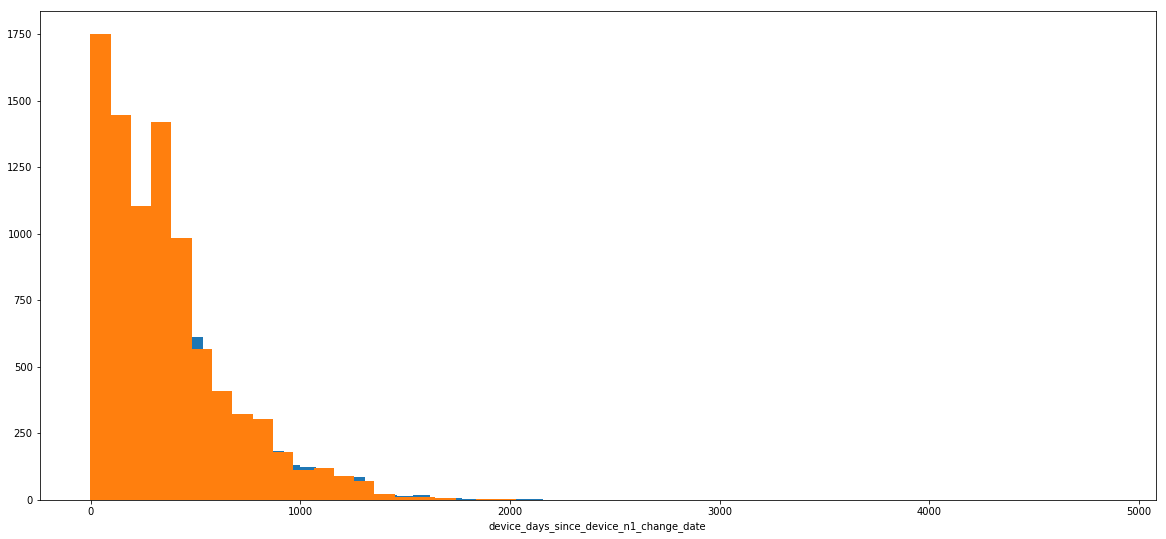

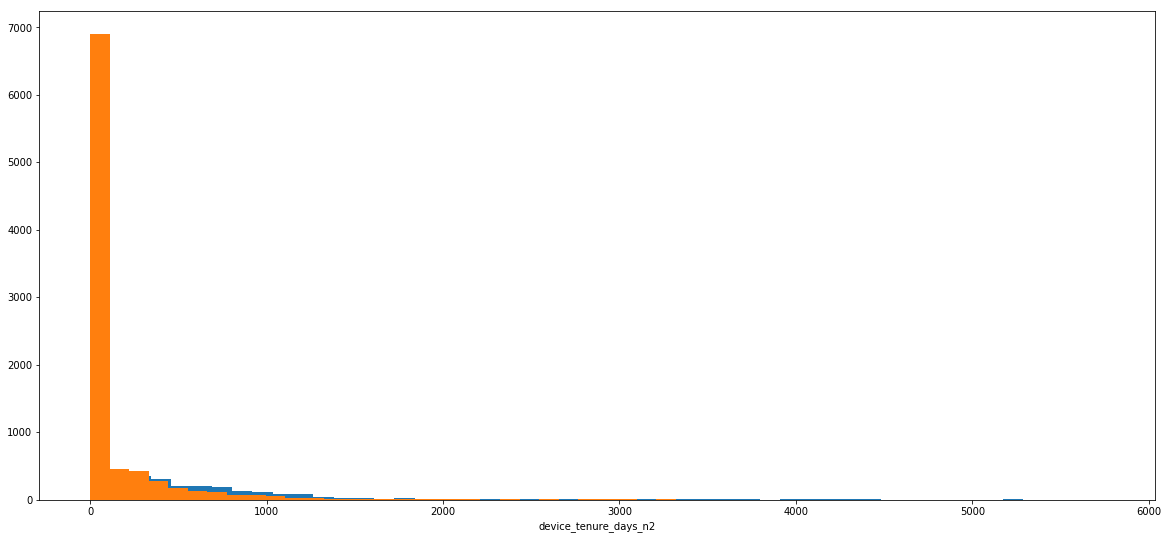

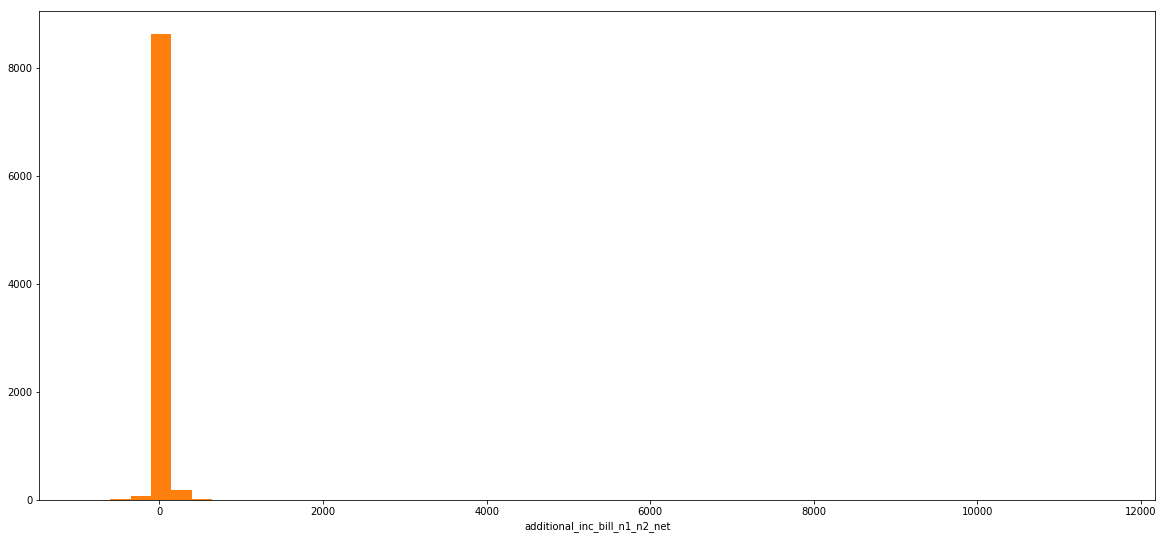

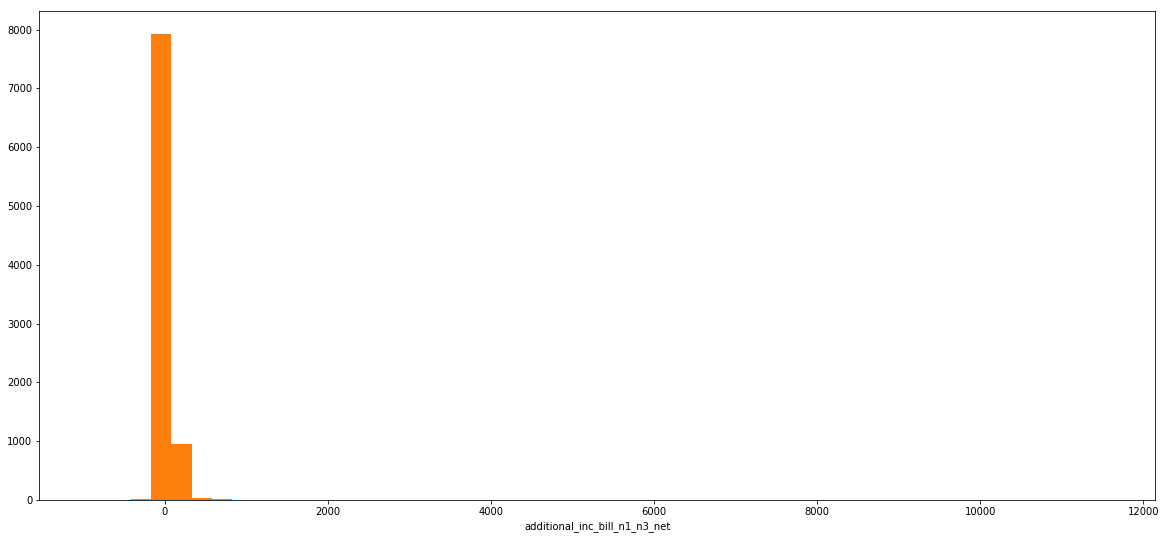

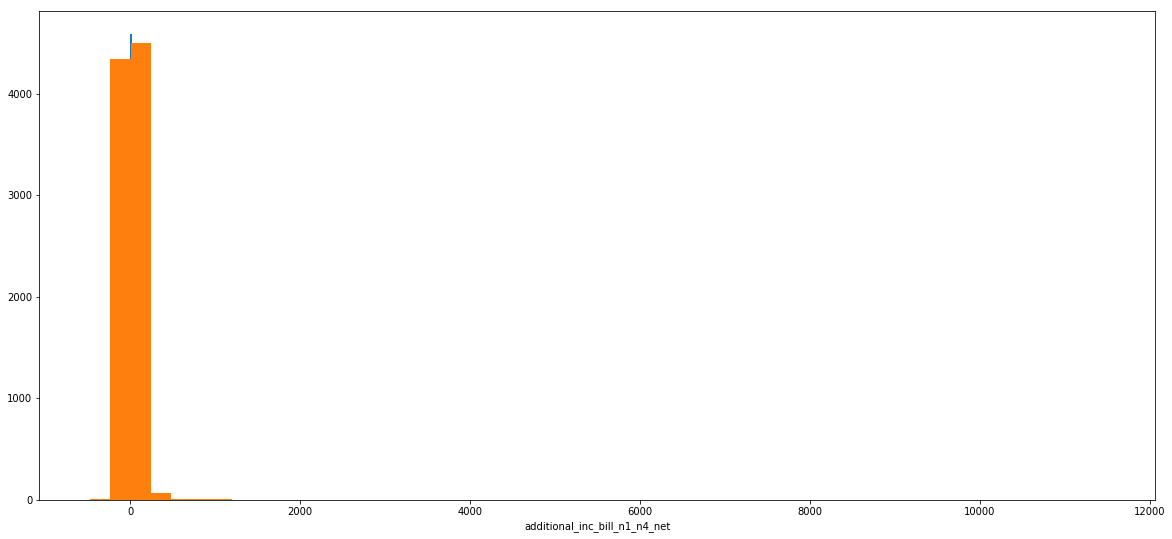

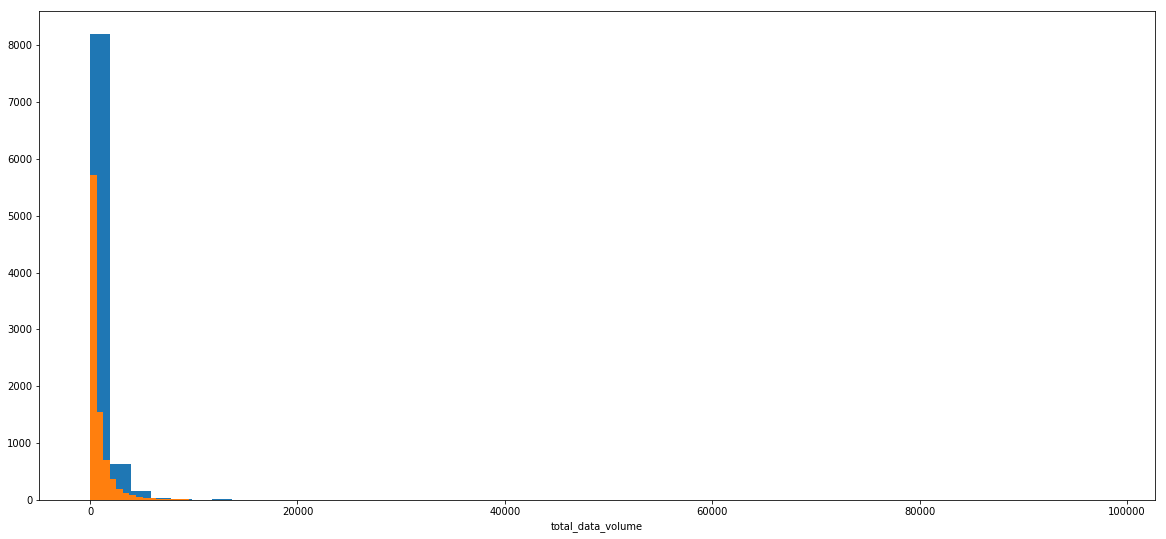

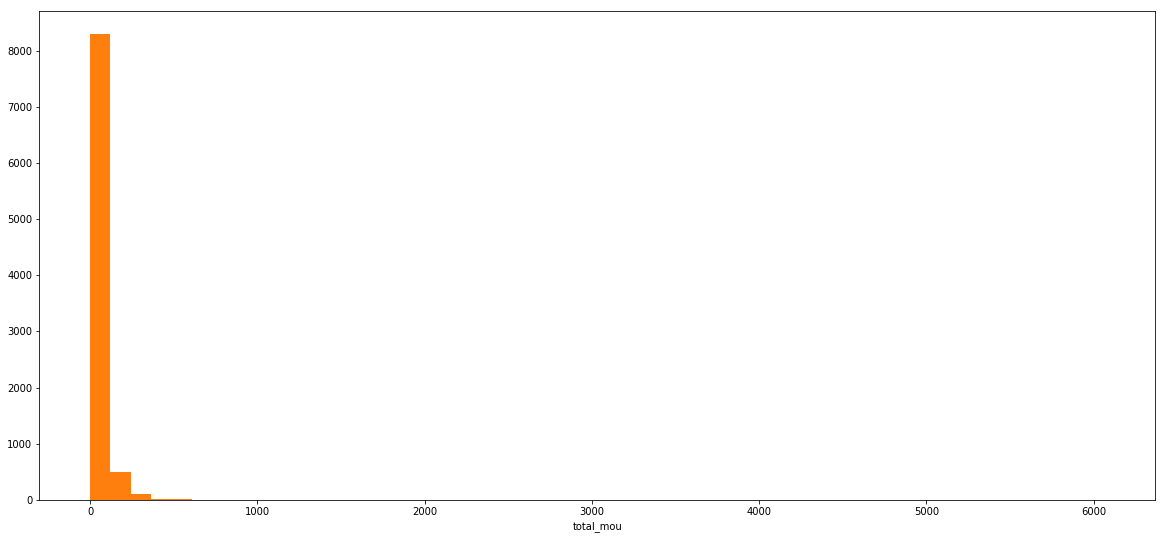

In [203]:

for col_ in numerical_feats:

    n = 50
    bins, counts = df_tr_preds.where(col('label') == 0).select(col_).rdd.flatMap(lambda x: x).histogram(n)

    bins2, counts2 = df_tr_preds.where(col('label') == 1).select(col_).rdd.flatMap(lambda x: x).histogram(n)

    plt.figure()
    plt.hist(bins[:-1], bins=bins, weights=counts)
    plt.hist(bins2[:-1], bins=bins2, weights=counts2)
    plt.xlabel(col_)

ccc_num_interactions
additional_inc_bill_n1_n4_net
device_days_since_device_n1_change_date


<Figure size 1440x648 with 0 Axes>

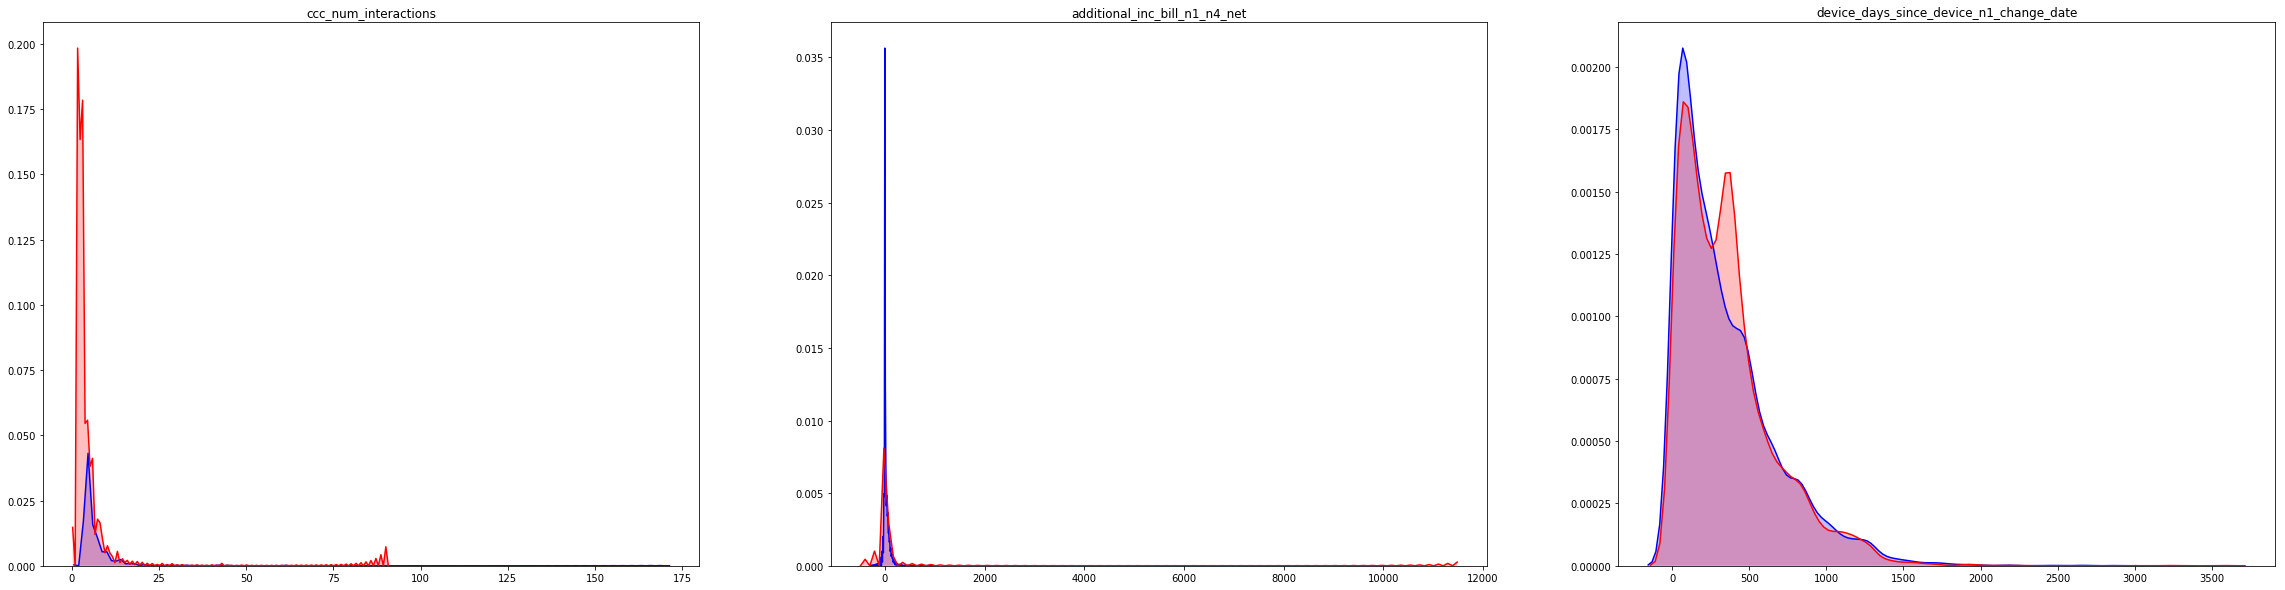

In [367]:
#%matplotlib inline  

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_features_churn_seaborn_shade2(df, var_to_plot, label,  image_per_row = 3, hist = False):
    plt.figure()
    inf = df.filter(df[label] == 0)
    sup = df.filter(df[label] == 1)
    inf.cache()
    sup.cache()
    fig_cat, axes = plt.subplots(int(np.round(len(var_to_plot)/ image_per_row)), image_per_row, figsize=(40, 10*int(np.round(len(var_to_plot)/ image_per_row))), squeeze=False)
    for i, ax in enumerate(fig_cat.axes):
        sel_ = var_to_plot[i]
        print(var_to_plot[i])

        arr = [float(row[sel_]) for row in inf.select(sel_).collect()]
        sns.kdeplot(arr, shade= True, color = 'blue', ax=axes[int(i/image_per_row)][i%image_per_row])
        #print("Half subplot")
        arr2 = [float(row[sel_]) for row in sup.select(sel_).collect()]
        sns.kdeplot(arr2, shade= True, color = 'red', ax=axes[int(i/image_per_row)][i%image_per_row])
        
        axes[int(i/image_per_row)][i%image_per_row].set_title(sel_)
    inf.unpersist()
    sup.unpersist()

    
plot_features_churn_seaborn_shade2(df_tr, var_to_plot=["ccc_num_interactions", "additional_inc_bill_n1_n4_net", "device_days_since_device_n1_change_date"], label="label", image_per_row = 3, hist = False)



In [ ]:


#train = modeler.get_model_info().get("model train metrics")["scores"]
#test = modeler.get_model_info().get("model test metrics")["scores"]

# from pykhaos.reporting.utils.plots import univariate_analysis, univariate_hist
# df_uni = univariate_analysis(df_pandas, "ccc_num_interactions", target="label", sort=None) # rows=num tarifas || cols [u'TARIFF', u'positivo', u'total', u'frec_loc', u'frec'], dtype='object')

# univariate_hist(df_uni, "ccc_num_interactions", sort = None)

In [ ]:
# %matplotlib inline
# import numpy as np
# import pandas as pd
# df_ = df_pandas.copy()

# df_pivot_label = pd.pivot_table(df_[["label", "ccc_num_interactions"]], columns="label", index="ccc_num_interactions", aggfunc=lambda x: len(x))
# df_pivot_label.columns=["0", "1"]
# import matplotlib.pyplot as plt
# ax = df_pivot_label[['0','1']].plot(kind='bar', title ="V comp", figsize=(15, 10), legend=True, fontsize=8)
# ax.set_ylabel("V", fontsize=12)
# plt.show()

# k-Means Segmentation

https://rsandstroem.github.io/sparkkmeans.html

Cluster Centers: 
[360.61913779 447.05838559  39.81534747]
[  308.61627907 13576.19886673    97.48449599]
[ 308.37843666 3175.86924118   51.56981125]


,prediction,NUM_CLIENTE,ccc_num_interactions,ccc_num_ivr_interactions,device_days_since_device_n1_change_date,device_tenure_days_n2,additional_inc_bill_n1_n2_net,additional_inc_bill_n1_n3_net,additional_inc_bill_n1_n4_net,total_data_volume,total_mou,label
msisdn,,,,,,,,,,,,
601152251,0,770967509,4,1,290,-1,0.00,0.00,0.000000,756.407227,6.633333,0
602447863,0,988774371,2,1,347,-1,1.66,-6.61,55.209999,1476.935547,223.199997,1
605893511,0,487840780,3,1,477,-1,-2.74,0.25,-0.750000,144.656250,28.483334,1
606743157,0,008686312,1,1,1343,-1,0.25,0.25,68.220001,4.215820,10.433333,0
606923417,0,340043850,1,1,32,1221,16.42,16.42,16.420000,105.114258,8.800000,0


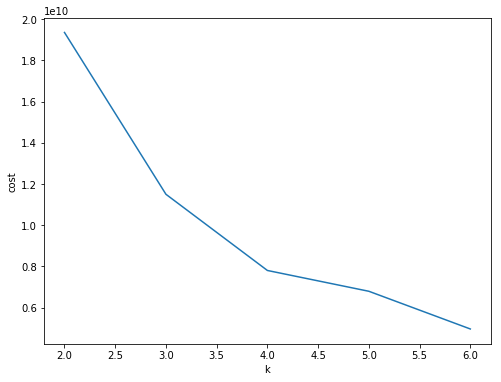

In [235]:
from pyspark.ml.clustering import KMeans

clust_feats = ["device_days_since_device_n1_change_date", "ccc_num_interactions", "total_data_volume", "total_mou"]



vecAssembler = VectorAssembler(inputCols=clust_feats, outputCol="features")
df_kmeans = vecAssembler.transform(df_tr).select('msisdn', 'features')


#----

N = 7

cost = np.zeros(N)
for k in range(2,N):
    kmeans = KMeans().setK(k).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans) #.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

#In [14]:

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,N),cost[2:N])
ax.set_xlabel('k')
ax.set_ylabel('cost')

#----

k = 3 # nb of clusters
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
kmeans_model = kmeans.fit(df_kmeans)
centers = kmeans_model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)
    
#----

transformed = kmeans_model.transform(df_kmeans)
df_pred =  transformed.select('msisdn', 'prediction')
# rows = transformed.collect()
# print(rows[:3])

#---

# df_pred = spark.createDataFrame(rows)
# df_pred.head()

#---


#Join the prediction with the original data

#The x, y, z from the original dataframe can be added to the newly created dataframe by joining the two dataframes on the 'id' column.
# "prediction" is the cluster number

df_pred = df_pred.join(df_tr, 'msisdn')
#df_pred.show()

#----
# !!!!!!!!!!!!!!!!!

pddf_pred = df_pred.toPandas().set_index('msisdn')
pddf_pred.head()

#-----





In [236]:
from mpl_toolkits.mplot3d import Axes3D


fig_size = [20,9]
plt.rcParams["figure.figsize"] = fig_size
clusters_colors=["red", "yellow", "blue", "green"]
clusters_markers=["o", "^", "x", "."]
N_CLUSTERS = 3
features = clust_feats
for f1 in range(0,len(features)):
    for f2 in range(0,len(features)):
        for f3 in range(0,len(features)):
            if f1==f2 or f2==f3 or f1==f3:
                continue
            print(f1,f2,f3,features[f1],features[f2],features[f3])
            fig = plt.figure()
            ax_all = Axes3D(fig)
            

            for i, c in enumerate(centers):
                print(c[f1], c[f2], c[f3], '$%d$' % i)
                
                #Draw white circles at cluster centers
                _ = ax_all.scatter3D(c[f1], c[f2], c[f3], marker='o', c="white", alpha=1, s=400, edgecolor='k')
                _ = ax_all.scatter3D(c[f1], c[f2], c[f3], marker='$%d$' % i, alpha=1, s=250, edgecolor='k')
             
                data_cluster = pddf_pred[pddf_pred["prediction"] == i]
                _ = ax_all.scatter3D(data_cluster[clust_feats[f1]], data_cluster[clust_feats[f2]], data_cluster[clust_feats[f3]], alpha=0.8, c=clusters_colors[i], marker=clusters_markers[i], edgecolor='k', s=100)


            _ = ax_all.set_xlabel(features[f1]);
            _ = ax_all.set_ylabel(features[f2]);
            _ = ax_all.set_zlabel(features[f3]);

            plt.show()
            break
        break
    


In [237]:
pddf_pred.groupby("prediction")["NUM_CLIENTE"].count()
#pddf_pred[pddf_pred["prediction"]==1] 

prediction
0    15843
1       86
2     1855
Name: NUM_CLIENTE, dtype: int64

In [ ]:
# fig = plt.figure()
# threedee = Axes3D(fig)
# threedee.scatter3D(pddf_pred[clust_feats[0]], pddf_pred[clust_feats[1]], pddf_pred[clust_feats[2]], c=pddf_pred.prediction)
# threedee.set_xlabel('x')
# threedee.set_ylabel('y')
# threedee.set_zlabel('z')
# plt.show()

# Decision tree

### Fit a decision tree classifier and extract metrics for tr, tt and val

In [368]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

assemblerInputs = ["device_days_since_device_n1_change_date", "ccc_num_interactions", "device_days_since_device_n1_change_date"]
#assemblerInputs = feat_cols
assembler_simple = VectorAssembler(inputCols=assemblerInputs, outputCol="features_simple")
pipeline = Pipeline(stages = [assembler_simple])
pipelineModel = pipeline.fit(df_tr.select(assemblerInputs))

df_tr_dtree = pipelineModel.transform(df_tr)

# selectedCols = ['label', 'features_simple'] #+ cols
# df_tr_pipe = df_tr_preds_dtree.select(selectedCols)
# df_tr_pipe.printSchema()

#df_tr_preds_dtree.groupBy('label').agg(sql_count('*')).show()

dtree = DecisionTreeClassifier(featuresCol = 'features_simple', labelCol = 'label', maxDepth = 4, minInstancesPerNode=50)
dtree_model = dtree.fit(df_tr_dtree)

#print("Train Area Under ROC: " + str(evaluator.evaluate(df_tr_preds_dtree, {evaluator.metricName: "areaUnderROC"})))

df_tr_preds_dtree = dtree_model.transform(pipelineModel.transform(df_tr))

df_tt_preds_dtree = dtree_model.transform(pipelineModel.transform(df_tt))
df_val_preds_dtree = dtree_model.transform(pipelineModel.transform(df_next_tar))

evaluator = BinaryClassificationEvaluator()

print("Train Area Under ROC: " + str(evaluator.evaluate(df_tr_preds_dtree, {evaluator.metricName: "areaUnderROC"})))

print("Test Area Under ROC: " + str(evaluator.evaluate(df_tt_preds_dtree, {evaluator.metricName: "areaUnderROC"})))
print("Val Area Under ROC: " + str(evaluator.evaluate(df_val_preds_dtree, {evaluator.metricName: "areaUnderROC"})))


Train Area Under ROC: 0.488807977253
Test Area Under ROC: 0.494090298506
Val Area Under ROC: 0.485370927179


## Print decision rules

In [369]:
import re
explanation = dtree_model.toDebugString.splitlines()
for i in range(0, len(assemblerInputs)):
    for ii_ll in range(0, len(explanation)):
        explanation[ii_ll] = explanation[ii_ll].replace("feature {}".format(i), "'{}'".format(assemblerInputs[i]))
#         explanation[ii_ll] = re.sub("Predict: 0.0", "Predict: NO_CHURN", explanation[ii_ll])
#         explanation[ii_ll] = re.sub("Predict: 1.0", "Predict: CHURN", explanation[ii_ll])
explanation

[u'DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4a63b230baf110fc7d26) of depth 4 with 29 nodes',
 u"  If ('ccc_num_interactions' <= 1.5)",
 u"   If ('device_days_since_device_n1_change_date' <= 33.5)",
 u"    If ('device_days_since_device_n1_change_date' <= 15.5)",
 u'     Predict: 0.0',
 u"    Else ('device_days_since_device_n1_change_date' > 15.5)",
 u"     If ('device_days_since_device_n1_change_date' <= 23.5)",
 u'      Predict: 0.0',
 u"     Else ('device_days_since_device_n1_change_date' > 23.5)",
 u'      Predict: 0.0',
 u"   Else ('device_days_since_device_n1_change_date' > 33.5)",
 u"    If ('device_days_since_device_n1_change_date' <= 308.5)",
 u"     If ('device_days_since_device_n1_change_date' <= 187.5)",
 u'      Predict: 0.0',
 u"     Else ('device_days_since_device_n1_change_date' > 187.5)",
 u'      Predict: 0.0',
 u"    Else ('device_days_since_device_n1_change_date' > 308.5)",
 u"     If ('device_days_since_device_n1_change_date' <= 430.5)",
 u'      P

# Manual segmentation - discretización

Add variables to compute the churn rate both individually and ijn groups of 2, 3 and4 variables

In [330]:
from pyspark.ml.feature import QuantileDiscretizer

# Actual variables
C1 = 'ccc_num_interactions'
C2 = 'device_days_since_device_n1_change_date'
C3 = 'additional_inc_bill_n1_n4_net'
C4 = "total_data_volume"
C5 = None

# Name of the discretized variables
C1_disc = "num_ccc"
C2_disc = "days_device_change"
C3_disc = "billing_inc"
C4_disc = "total_data_volume_disc"
C5_disc = None

var_dict = {C1:[C1_disc,3], C2:[C2_disc,5], C3:[C3_disc,5], C4:[C4_disc,5], C5:[C5_disc,5]}

for var,cc in var_dict.items():
    if var == cc[0]:
        print("discrete variable must be different to actual column")
        sys.exit()
    if cc[0] and cc[0] in df_tar.columns: :
        print("dropping {}".format(cc[0]))
        df_tar = df_tar.drop(cc[0])

        
df_tar = df_tar.withColumn(C1_disc, when(col(C1)==1, "CCC=1").when(col(C1)==2, "CCC=2").otherwise("CCC>2"))

splits_dict = {}
for var,cc in var_dict.items():
    if var == 'ccc_num_interactions' or not var: continue
    discretizer = QuantileDiscretizer(numBuckets=cc[1], inputCol=var, outputCol=cc[0], relativeError=0)
    bucketizer = discretizer.fit(df_tar)
    df_tar = bucketizer.transform(df_tar)
    splits_dict[cc[0]] = bucketizer.getSplits()
    df_tar.columns
    
refprevalence = df_tar.select(label_col).rdd.map(lambda r: r[label_col]).mean()
refprevalence_all = df_tar_all.select(label_col).rdd.map(lambda r: r[label_col]).mean()

dropping days_device_change
dropping num_ccc
dropping billing_inc
('device_days_since_device_n1_change_date', ['days_device_change', 5])
('additional_inc_bill_n1_n4_net', ['billing_inc', 5])
('total_data_volume', ['total_data_volume_disc', 5])


## All variables

In [379]:
myvars = [cc[0] for vv, cc in var_dict.items() if cc[0]]

df_GG = df_tar.select(*myvars + ["label"]).groupBy(*myvars).agg(sql_sum("label").alias("num_churners"),  sql_count("label").alias("num_msisdn")).withColumn("churn_rate", col("num_churners")/col("num_msisdn"))

for var,cc in var_dict.items():
    if not var or not cc[0] in splits_dict.keys(): continue
    mysplit = splits_dict[cc[0]]
    labels_dict = {ii:"({},{})".format(mysplit[ii],mysplit[ii+1]) for ii in range(0, len(mysplit)-1)}
    for num,label in labels_dict.items():
        df_GG = df_GG.withColumn(cc[0], when(col(cc[0])==num, labels_dict[num]).otherwise(col(cc[0])))
                                                       

df_GG = df_GG.withColumn("LIFT", col("churn_rate")/lit(refprevalence))
df_GG = df_GG.withColumn("LIFT_ALL", col("churn_rate")/lit(refprevalence_all)) 
df_GG = df_GG.sort(desc("LIFT"))
df_GG.show(100,truncate=False)

+------------------+-------+-----------------------------+----------------------------+------------+----------+--------------------+------------------+------------------+
|days_device_change|num_ccc|billing_inc                  |total_data_volume_disc      |num_churners|num_msisdn|churn_rate          |LIFT              |LIFT_ALL          |
+------------------+-------+-----------------------------+----------------------------+------------+----------+--------------------+------------------+------------------+
|(345.0,570.0)     |CCC>2  |(0.0,9.80000019073)          |(491.200195312,1093.4609375)|77          |1166      |0.0660377358490566  |2.620135372479741 |4.80902169685503  |
|(345.0,570.0)     |CCC=2  |(9.80000019073,49.3400001526)|(-inf,75.5625)              |49          |835       |0.058682634730538925|2.328311911832297 |4.273406106666386 |
|(345.0,570.0)     |CCC>2  |(9.80000019073,49.3400001526)|(222.875,491.200195312)     |60          |1075      |0.05581395348837209 |2.21449315202

## 1 variable

In [350]:
for i in range(0, len(myvars)):

    df_GG_simple = df_tar.select(*[myvars[i]] + ["label"]).groupBy(myvars[i]).agg(sql_sum("label").alias("num_churners"),  sql_count("label").alias("num_msisdn")).withColumn("churn_rate", col("num_churners")/col("num_msisdn"))

    for var,cc in var_dict.items():
        print(var, cc)
        if not var or not cc[0] in splits_dict.keys() or not cc[0] in df_GG_simple.columns: continue
        mysplit = splits_dict[cc[0]]
        labels_dict = {ii:"({},{})".format(mysplit[ii],mysplit[ii+1]) for ii in range(0, len(mysplit)-1)}
        for num,label in labels_dict.items():
            df_GG_simple = df_GG_simple.withColumn(cc[0], when(col(cc[0])==num, labels_dict[num]).otherwise(col(cc[0])))


    df_GG_simple = df_GG_simple.withColumn("LIFT", col("churn_rate")/lit(refprevalence))
    df_GG_simple = df_GG_simple.withColumn("LIFT_ALL", col("churn_rate")/lit(refprevalence_all)) 
    df_GG_simple = df_GG_simple.sort(desc("LIFT"))
    df_GG_simple.show(100,truncate=False)

('device_days_since_device_n1_change_date', ['days_device_change', 5])
('ccc_num_interactions', ['num_ccc', 3])
(None, [None, 5])
('additional_inc_bill_n1_n4_net', ['billing_inc', 5])
('total_data_volume', ['total_data_volume_disc', 5])
+------------------+------------+----------+--------------------+------------------+------------------+
|days_device_change|num_churners|num_msisdn|churn_rate          |LIFT              |LIFT_ALL          |
+------------------+------------+----------+--------------------+------------------+------------------+
|(345.0,570.0)     |3387        |101915    |0.03323357700044154 |1.3185865556008463|2.420146463296846 |
|(80.0,191.0)      |2538        |102662    |0.024721902943640295|0.9808745188614508|1.8003065386017292|
|(570.0,inf)       |2452        |102367    |0.02395303173874393 |0.9503685268717381|1.7443155471043048|
|(191.0,345.0)     |2423        |102077    |0.02373698286587576 |0.9417964992770889|1.7285823651009282|
|(-inf,80.0)       |2059        |10

## 2 variables

In [363]:
for i in range(0, len(myvars)):
    for j in range(0, len(myvars)):
        if i == j or i>j: continue

        df_GG_simple_2 = df_tar.select(*[myvars[i], myvars[j]] + ["label"]).groupBy(myvars[i],myvars[j]).agg(sql_sum("label").alias("num_churners"),  sql_count("label").alias("num_msisdn")).withColumn("churn_rate", col("num_churners")/col("num_msisdn"))

        for var,cc in var_dict.items():
            if not var or not cc[0] in splits_dict.keys() or not cc[0] in df_GG_simple_2.columns: continue
            mysplit = splits_dict[cc[0]]
            labels_dict = {ii:"({},{})".format(mysplit[ii],mysplit[ii+1]) for ii in range(0, len(mysplit)-1)}
            for num,label in labels_dict.items():
                df_GG_simple_2 = df_GG_simple_2.withColumn(cc[0], when(col(cc[0])==num, labels_dict[num]).otherwise(col(cc[0])))


        df_GG_simple_2 = df_GG_simple_2.withColumn("LIFT", col("churn_rate")/lit(refprevalence))
        df_GG_simple_2 = df_GG_simple_2.withColumn("LIFT_ALL", col("churn_rate")/lit(refprevalence_all)) 
        df_GG_simple_2 = df_GG_simple_2.sort(desc("LIFT"))
        df_GG_simple_2.show(5,truncate=False)

+------------------+-------+------------+----------+--------------------+------------------+------------------+
|days_device_change|num_ccc|num_churners|num_msisdn|churn_rate          |LIFT              |LIFT_ALL          |
+------------------+-------+------------+----------+--------------------+------------------+------------------+
|(345.0,570.0)     |CCC>2  |1082        |25398     |0.04260177966769037 |1.6902825089739715|3.102360795876487 |
|(345.0,570.0)     |CCC=2  |869         |23091     |0.03763371010350353 |1.4931677134604016|2.740574401802213 |
|(80.0,191.0)      |CCC>2  |924         |26425     |0.034966887417218546|1.3873579614659053|2.546370163950637 |
|(191.0,345.0)     |CCC>2  |854         |25019     |0.03413405811583197 |1.3543143465729253|2.485721594937018 |
|(570.0,inf)       |CCC>2  |802         |23531     |0.0340826994177893  |1.3522766216313298|2.4819815349541323|
+------------------+-------+------------+----------+--------------------+------------------+------------

### 3 variables

In [358]:
for i in range(0, len(myvars)):
    for j in range(0, len(myvars)):
        for k in range(0, len(myvars)):
            if i == j or i == k or j==k or i<j or j<k: continue
            
            df_GG_simple_3 = df_tar.select(*[myvars[i], myvars[j], myvars[k]] + ["label"]).groupBy(myvars[i],myvars[j], myvars[k]).agg(sql_sum("label").alias("num_churners"),  sql_count("label").alias("num_msisdn")).withColumn("churn_rate", col("num_churners")/col("num_msisdn"))
            for var,cc in var_dict.items():
                if not var or not cc[0] in splits_dict.keys() or not cc[0] in df_GG_simple_3.columns: continue
                mysplit = splits_dict[cc[0]]
                labels_dict = {ii:"({},{})".format(mysplit[ii],mysplit[ii+1]) for ii in range(0, len(mysplit)-1)}
                for num,label in labels_dict.items():
                    df_GG_simple_3 = df_GG_simple_3.withColumn(cc[0], when(col(cc[0])==num, labels_dict[num]).otherwise(col(cc[0])))


            df_GG_simple_3 = df_GG_simple_3.withColumn("LIFT", col("churn_rate")/lit(refprevalence))
            df_GG_simple_3 = df_GG_simple_3.withColumn("LIFT_ALL", col("churn_rate")/lit(refprevalence_all)) 
            df_GG_simple_3 = df_GG_simple_3.sort(desc("LIFT"))
            df_GG_simple_3.show(5,truncate=False)

['billing_inc', 'num_ccc', 'days_device_change', 'num_churners', 'num_msisdn', 'churn_rate']
('device_days_since_device_n1_change_date', ['days_device_change', 5])
('ccc_num_interactions', ['num_ccc', 3])
(None, [None, 5])
('additional_inc_bill_n1_n4_net', ['billing_inc', 5])
('total_data_volume', ['total_data_volume_disc', 5])
+-----------------------------+-------+------------------+------------+----------+--------------------+------------------+------------------+
|billing_inc                  |num_ccc|days_device_change|num_churners|num_msisdn|churn_rate          |LIFT              |LIFT_ALL          |
+-----------------------------+-------+------------------+------------+----------+--------------------+------------------+------------------+
|(0.0,9.80000019073)          |CCC>2  |(345.0,570.0)     |274         |5410      |0.05064695009242144 |2.0094853910298816|3.6882288398061127|
|(9.80000019073,49.3400001526)|CCC>2  |(345.0,570.0)     |252         |5149      |0.048941542046999416

In [63]:
spark

AttributeError: 'NoneType' object has no attribute 'sc'

In [62]:
import pandas as pd

df_pandas = pd.DataFrame({"days_since_start" : [45, 40, 30, 12, 10, 5],
                          "days_since_completed" : [44, 39, 29, 11, 9, 4],
                          "duration" : [1,1,1,1,1,1],
                          "num_cliente" : ["A", "A", "A", "A", "A", "B"],
                          "SLA_master" : [0.5, 1, 4, 5,3,6],
                          #"SLA_factor" : [0.5, 1, 4, 5,3,6],
                          "categ" : ["traslado", "traslado", "traslado", "gen", "traslado", "gen"]
                         })

df = spark.createDataFrame(df_pandas)

df = df.fillna(-1, subset=["days_since_start"])

df = df.sort(asc("num_cliente"), desc("days_since_start"))


In [67]:
days_range = [5,10, 40, 50]
factor_list = [1,2,3]

for dd in days_range:
    df = df.withColumn("duration_last{}".format(dd),
                                   when((col("days_since_completed") <= dd) & (col("days_since_completed") != -1),
                                        col("duration")).otherwise(None))
    df = df.withColumn("SLA_factor_last{}".format(dd),
                                   when(col("duration_last{}".format(dd)).isNotNull() & col("SLA_master").isNotNull(),
                                        col("duration_last{}".format(dd)) / col("SLA_master")).otherwise(None))

In [64]:
df.show()

+----------+--------+--------------------+----------------+--------+-----------+--------------+-------------------+---------------+-------------------+---------------+-------------------+
|SLA_master|   categ|days_since_completed|days_since_start|duration|num_cliente|duration_last5|   SLA_factor_last5|duration_last10|  SLA_factor_last10|duration_last50|  SLA_factor_last50|
+----------+--------+--------------------+----------------+--------+-----------+--------------+-------------------+---------------+-------------------+---------------+-------------------+
|       0.5|traslado|                  44|              45|       1|          A|          null|               null|           null|               null|              1|                2.0|
|       1.0|traslado|                  39|              40|       1|          A|          null|               null|           null|               null|              1|                1.0|
|       4.0|traslado|                  29|              30| 

In [69]:
from pyspark.sql.functions import lag, mean as sql_avg

df = df.withColumn("traslado", when(col("categ")=="traslado", 1).otherwise(0))

# to ignore an order, set the column "days_since..." to -1. following line, set "diff" value of days_since_started=-1 to Null
df = df.withColumn("diff", when(col("days_since_start")!=-1, lag(col("days_since_start"),-1).over(Window.partitionBy("num_cliente").orderBy(asc("days_since_start")))-col("days_since_start")).otherwise(None))
df = df.withColumn("days_since_start_traslados", when( col("traslado")==1, col("days_since_start")).otherwise(None))
df = df.withColumn("diff_traslados", when( ( (col("traslado")==1) & (col("days_since_start_traslados")!=-1)), lag(col("days_since_start_traslados"),-1).over(Window.partitionBy("num_cliente").orderBy(asc("days_since_start_traslados")))-col("days_since_start_traslados")).otherwise(None))

df.select("num_cliente", "days_since_start", "traslado", "diff", "diff_traslados", "days_since_start_traslados", "SLA_factor_last40").sort(asc("num_cliente"), desc("days_since_start")).show()

# # diff=null entries are ignored for average
# df.groupby("num_cliente").agg( sql_avg(col("diff")).alias("avg"),
#                                sql_sum(col("diff")).alias("sum"),
#                                sql_sum(col("diff")).alias("sum2")).show()

+-----------+----------------+--------+----+--------------+--------------------------+-------------------+
|num_cliente|days_since_start|traslado|diff|diff_traslados|days_since_start_traslados|  SLA_factor_last40|
+-----------+----------------+--------+----+--------------+--------------------------+-------------------+
|          A|              45|       1|null|          null|                        45|               null|
|          A|              40|       1|   5|             5|                        40|                1.0|
|          A|              30|       1|  10|            10|                        30|               0.25|
|          A|              12|       0|  18|          null|                      null|                0.2|
|          A|              10|       1|   2|            20|                        10| 0.3333333333333333|
|          B|               5|       0|null|          null|                      null|0.16666666666666666|
+-----------+----------------+-------

In [78]:
(1+0.25+0.3333333+0.2)/4

0.445833325

In [70]:


df_agg = (df.groupby("num_cliente").agg(*([sql_count(when(((col("days_since_start") < dd) & (col("days_since_start") != -1)), col("days_since_start")).otherwise(None)).alias("nb_started_orders_last{}".format(dd)) for dd in days_range] +
                                                [sql_count(when(col("duration_last{}".format(dd)).isNotNull(), col("duration_last{}".format(dd))).otherwise(None)).alias("nb_completed_orders_last{}".format(dd)) for dd in days_range] +
                                                [sql_count(when(col("SLA_factor_last{}".format(dd)) > ff, col("SLA_factor_last{}".format(dd))).otherwise(None)).alias("nb_completed_orders_last{}_{}SLA".format(dd, ff)) for dd in days_range for ff in factor_list] +
                                                [sql_avg(col("diff")).alias("avg_days_bw_open_orders")] +
                                                # ignore null factors (when SLA_master is null)
                                                [sql_avg(col("SLA_factor_last{}".format(dd))).alias("mean_sla_factor_last{}".format(dd)) for dd in days_range] +
                                                # traslados
                                                [sql_count(when((  (col("days_since_start_traslados").isNotNull()) & (col("days_since_start_traslados") < dd) ), col("days_since_start_traslados")).otherwise(None)).alias("nb_started_orders_traslados_last{}".format(dd)) for dd in days_range] +
                                                [sql_count(when( ((col("traslado") == 1) & col("duration_last{}".format(dd)).isNotNull()), col("duration_last{}".format(dd))).otherwise(None)).alias("nb_completed_orders_traslados_last{}".format(dd)) for dd in days_range] +
                                                [sql_count(when( ((col("traslado") == 1) & (col("SLA_factor_last{}".format(dd)) > ff)), col("SLA_factor_last{}".format(dd))).otherwise(None)).alias("nb_completed_orders_last{}_{}SLA".format(dd, ff)) for dd in days_range for ff in factor_list] +
                                                [sql_avg(col("diff_traslados")).alias("avg_days_bw_open_orders_traslado")] +
                                                # ignore null factors (when SLA_master is null)
                                                [sql_avg(when( col("traslado") == 1,  col("SLA_factor_last{}".format(dd))).otherwise(None)).alias("mean_sla_factor_traslados_last{}".format(dd)) for dd in days_range]
                                              )))

In [72]:
df_agg.select("num_cliente", 'avg_days_bw_open_orders_traslado',  "nb_started_orders_traslados_last10","nb_started_orders_traslados_last50",
 'mean_sla_factor_traslados_last50',
 'mean_sla_factor_traslados_last40', 'mean_sla_factor_last40',

              ).show()

+-----------+--------------------------------+----------------------------------+----------------------------------+--------------------------------+--------------------------------+----------------------+
|num_cliente|avg_days_bw_open_orders_traslado|nb_started_orders_traslados_last10|nb_started_orders_traslados_last50|mean_sla_factor_traslados_last50|mean_sla_factor_traslados_last40|mean_sla_factor_last40|
+-----------+--------------------------------+----------------------------------+----------------------------------+--------------------------------+--------------------------------+----------------------+
|          B|                            null|                                 0|                                 0|                            null|                            null|   0.16666666666666666|
|          A|              11.666666666666666|                                 0|                                 4|              0.8958333333333333|              0.52777777777

In [54]:
df.groupby("num_cliente").agg( *[sql_sum(col("diff")).alias("sum{}{}".format(ii,jj)) for ii in range(0,10) for jj in range(0,2)]).show()
                               

+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|num_cliente|sum00|sum01|sum10|sum11|sum20|sum21|sum30|sum31|sum40|sum41|sum50|sum51|sum60|sum61|sum70|sum71|sum80|sum81|sum90|sum91|
+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|          B|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|  2.0|
|          A| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0| 15.0|
+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+

